In [1]:
import os
import json
import torch
import optuna
import pickle
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from plotly.io import show
from secret import general
import matplotlib.pyplot as plt
from joblib import Parallel, delayed, cpu_count
from pandas.tseries.holiday import USFederalHolidayCalendar
from darts.models import TFTModel
from darts import TimeSeries, concatenate
from darts.explainability import TFTExplainer
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics.metrics import (
    mae, mape, rmse, smape, mse, rmsle,
    r2_score, coefficient_of_variation
)
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_CUDA_ALLOC_SYNC'] = "1"
torch.cuda.empty_cache()
torch.set_grad_enabled(True)

class ModelEvaluator:
    def __init__(self, models: dict = None):
        self.predictions = None
        # Check accelerator
        self.accelerator = 'cuda'
        if not torch.cuda.is_available():
            self.accelerator = 'cpu'
            print("WARNING: training on CPU, a painfully slow process")

        # Load settings -----------------------------------------------------
        self.models = models or general.update({
            "models": self.model_info,
        })
        self.models.update({"protected_columns": [
                self.models.get("time_col_name", "Datetime"), 
                self.models.get("group_col_name", "Ticker")
                ]
            }
        )
        torch.set_float32_matmul_precision(self.models["float_precision"])

        # Load dataset -----------------------------------------------------
        data_path = self.models.get("data_path", "Data/data.csv")
        file_extension = os.path.splitext(data_path)[-1]

        if file_extension == '.csv':
            self.raw_data = pd.read_csv(data_path)
        elif file_extension == '.xlsx':
            self.raw_data = pd.read_excel(data_path)
        elif file_extension == '.parquet':
            self.raw_data = pd.read_parquet(data_path)
        else:
            raise ValueError("Unsupported file type. Please provide a .csv, .xlsx, or .parquet file.")

        print(f"Original data shape: {self.raw_data.shape}")
        
        # Cleanup -------------------------------------------------------------
        self.data = self.raw_data.copy()
        # Remove duplicate rows
        self.data.drop_duplicates(inplace=True)
        # Remove duplicate columns, excluding protected columns
        constant_columns = [col for col in self.data.columns if self.data[col].nunique() == 1 and col not in self.models["protected_columns"]]
        self.data = self.data.drop(columns=constant_columns)
        # Reduce the data to the smallest numeric type
        self.data = self.optimize_data_types(self.data)
        # Remove unhelpful features by correlation
        self.data = self.check_corrs(self.data, self.models)
        self.data.to_csv("new_data.csv")
        # Ensure correct date column format
        self.data[self.models["time_col_name"]] = pd.to_datetime(self.data[self.models["time_col_name"]])
        # Determine static and value columns
        self.value_cols, self.static_cols = self.determine_columns()
        print(f"Found {len(self.value_cols)} value columns and {len(self.static_cols)} static columns")

        # Assuming no future cov cols in dataset, simply remove target for past cov cols
        self.past_covariate_cols = [col for col in self.value_cols if col != self.models["target"]]
        
        # Create TimeSeries object for the new data ----------------------------
        self.split_data = TimeSeries.from_group_dataframe(
                self.data,
                group_cols=self.models["group_col_name"],
                time_col=self.models["time_col_name"],
                value_cols=self.value_cols,
                static_cols=self.static_cols if len(self.static_cols) > 0 else None,
        )
        self.fit_kwargs_list = self.prepare_fit_kwargs()
        self.time = dt.datetime.now().strftime("%Y%m%d%H%M%S")

    def optimize_data_types(self, data, force_int=False):
        """
        Determines the optimal data type for a pandas Series or DataFrame

        Parameters:
            data: pd.Series or pd.DataFrame
                Data to analyze
            force_int: bool, default False
                Forces the function to treat the series as integers

        Returns:
            If input is a Series, returns a numpy.dtype suggested based on the series values.
            If input is a DataFrame, returns a DataFrame with optimized data types.
        """

        def optimize_series(series):
            # Try converting to numeric if the series is of object type
            if not isinstance(series, pd.Series):
                return series
            
            # Drop NaN values for analysis
            series = series.dropna()

            if pd.api.types.is_integer_dtype(series) or force_int or (
                pd.api.types.is_float_dtype(series) and all(
                series.apply(lambda x: float(x).is_integer()))
            ):
                min_val, max_val = series.min(), series.max()
                if min_val >= 0:
                    if max_val <= np.iinfo(np.uint8).max:
                        return series.astype(np.uint8)
                    elif max_val <= np.iinfo(np.uint16).max:
                        return series.astype(np.uint16)
                    elif max_val <= np.iinfo(np.uint32).max:
                        return series.astype(np.uint32)
                    elif max_val <= np.iinfo(np.uint64).max:
                        return series.astype(np.uint64)
                else:
                    if np.iinfo(np.int8).min <= min_val <= max_val <= np.iinfo(np.int8).max:
                        return series.astype(np.int8)
                    elif np.iinfo(np.int16).min <= min_val <= max_val <= np.iinfo(np.int16).max:
                        return series.astype(np.int16)
                    elif np.iinfo(np.int32).min <= min_val <= max_val <= np.iinfo(np.int32).max:
                        return series.astype(np.int32)
                    elif np.iinfo(np.int64).min <= min_val <= max_val <= np.iinfo(np.int64).max:
                        return series.astype(np.int64)
            elif pd.api.types.is_float_dtype(series):
                min_val, max_val = series.min(), series.max()
                if np.finfo(np.float16).min <= min_val <= max_val <= np.finfo(np.float16).max:
                    return series.astype(np.float16)
                elif np.finfo(np.float32).min <= min_val <= max_val <= np.finfo(np.float32).max:
                    return series.astype(np.float32)
                elif np.finfo(np.float64).min <= min_val <= max_val <= np.finfo(np.float64).max:
                    return series.astype(np.float64)
                elif np.finfo(np.longdouble).min <= min_val <= max_val <= np.finfo(np.longdouble).max:
                    return series.astype(np.longdouble)
            else:
                return series

        if isinstance(data, pd.Series):
            return optimize_series(data)
        elif isinstance(data, pd.DataFrame):
            data.index = optimize_series(data.index.astype(int))
            for col in data.columns:
                data[col] = optimize_series(data[col])
            return data
        else:
            raise ValueError("Input must be a pandas Series or DataFrame")

    def check_corrs(self, df, settings):
        # Select only numeric columns for correlation analysis
        numeric_df = df.select_dtypes(include=[np.number])
        # Calculate the correlation matrix for numeric columns
        correlation_matrix = numeric_df.corr()
        # Focus on the correlation of all features with respect to target
        correlation_with_target = correlation_matrix[settings["target"]].sort_values(key=abs, ascending=False)
        # Take the absolute value of the correlation coefficients
        abs_correlation_with_target = correlation_with_target.abs()
        # Drop the target itself
        abs_correlation_with_target = abs_correlation_with_target.drop(settings["target"])
        # Sort by absolute value
        sorted_abs_correlation = abs_correlation_with_target.sort_values(ascending=False)
        # Select top 10 and bottom 10 features
        top_10_features = sorted_abs_correlation.head(10).index.tolist()
        bottom_10_features = sorted_abs_correlation.tail(10).index.tolist()
        # Combine them
        selected_features = top_10_features + bottom_10_features
        # Include target to the selected features for the heatmap
        selected_features.append(settings["target"])

        filtered_df = df
        if 0.0 < settings["corr_thresh"] < 1.0:
            # Drop columns based on the correlation threshold, keeping protected columns
            drop_columns = sorted_abs_correlation[sorted_abs_correlation < settings["corr_thresh"]].index.tolist()
            drop_columns = [col for col in drop_columns if col not in settings["protected_columns"]]
            filtered_df = df.drop(columns=drop_columns)
            print(f"New data shape: {filtered_df.shape}")
            print(f"Dropped {df.shape[1]-filtered_df.shape[1]} columns due to low feature correlation with target")
            
        if settings["plot"] > 0:
            # Generate the heatmap
            plt.figure(figsize=(14, 10))
            sns.heatmap(df[selected_features].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
            plt.title(f'Correlation Heatmap of Top and Bottom Numeric Features with {settings["target"]}')
            plt.show()
            plt.figure(figsize=(10, 6))
            sns.histplot(abs_correlation_with_target, bins=20, kde=False, color='blue')
            plt.xlabel(f'Absolute Correlation with {settings["target"]}')
            plt.ylabel('Frequency')
            plt.title(f'Distribution of Absolute Correlations with {settings["target"]}')
            plt.grid(True)
            plt.show()

        return filtered_df

    def encode_us_holidays(self, index, pred_len=0):
        cal = USFederalHolidayCalendar()
        holidays = cal.holidays(start=index.min(), end=index.max()+pd.Timedelta(days=pred_len))
        return index.isin(holidays).astype(float)

    def plt_predictions(self, val_series, pred_series, model_name, stock_name):
        # Plot actual series
        plt.figure(figsize=(12, 9))

        # Calculate the desired length of validation data to plot
        desired_val_len = len(pred_series) * 2

        # Ensure enough validation data exists
        actual_val_len = min(len(val_series), desired_val_len)

        # Calculate the starting point for slicing the validation data
        val_start_idx = len(val_series) - actual_val_len

        # Slice the validation series
        val_series_slice = val_series[val_start_idx:]

        # Align the prediction series with the validation slice
        pred_series = pred_series.slice_intersect(val_series_slice)  

        # Plot the validation slice and the aligned predictions
        val_series_slice.plot(label='Actual Data')
        pred_series.plot(label='Predictions')
        
        mape_value = mape(val_series_slice, pred_series)
        plt.title(f"{model_name} - {stock_name} - MAPE: {mape_value:.2f}%")
        plt.legend()
        plt.show()

    def determine_columns(self):
        """
        Determines which columns in the dataset should be treated as static covariates
        and which should be treated as value columns for time series modeling. 

        This is done by analyzing the uniqueness of values within each column, 
        grouped by the time series identifier (e.g., ticker symbol).
        Columns with constant values across a time series are considered static.

        Returns:
            Tuple[List[str], List[str]]: A tuple containing two lists:
                - The first list contains the names of the value columns.
                - The second list contains the names of the static covariate columns.
        """
        group_col = self.models["group_col_name"]
        time_col = self.models["time_col_name"]
        target_col = self.models["target"]

        static_cols = []
        value_cols = []

        for col in self.data.columns:
            if col not in [group_col, time_col]:
                if (self.data[col].nunique() == 1):
                        static_cols.append(col)
                else:
                    value_cols.append(col)

        if target_col not in value_cols:
            raise ValueError(f"The target column '{target_col}' must be present in the dataset.")

        return value_cols, static_cols

    def prepare_ts(self, stock, past_covariate_cols, future_attrs=None):
        split = int(len(stock) * self.models["train_test_pct"]) if isinstance(self.models["train_test_pct"], float) else len(stock) - self.models["train_test_pct"]
        train, val = stock[:split], stock[split:]

        method = self.models["scaling_method"]()

        # Fit the scaler on the training data only
        scaler = Scaler(method)

        # Transform both training and validation data using the scaler fitted on training data
        target_train_transformed = scaler.fit_transform(train[self.models["target"]])
        target_val_transformed = scaler.transform(val[self.models["target"]])

        # Generate future covariates
        future_cov = [] 
        cov_scaler = Scaler(method)

        if future_attrs is None:
            future_attrs = ["week", "month", "quarter"]

        for attr in future_attrs:
            temp_cov = datetime_attribute_timeseries(
                stock.time_index, attribute=attr, one_hot=False, add_length=self.models["max_prediction_length"]
            )
            future_cov.append(temp_cov)
        
        future_cov = concatenate(future_cov, axis=1)
        future_cov = future_cov.astype(np.float32)
        
        # Fit the covariate scaler on the entire future_cov
        train_future_cov, val_future_cov = future_cov[:len(train)], future_cov[len(train):]
        tf_train_future_cov = cov_scaler.fit_transform(train_future_cov)
        tf_val_future_cov = cov_scaler.transform(val_future_cov)
        future_cov = concatenate([tf_train_future_cov, tf_val_future_cov])

        # Generate past covariates
        train_past_cov = cov_scaler.fit_transform(train[past_covariate_cols])
        val_past_cov = cov_scaler.transform(val[past_covariate_cols])
        past_cov = concatenate([train_past_cov, val_past_cov])

        return scaler, target_train_transformed, target_val_transformed, past_cov, future_cov

    def prepare_fit_kwargs(self, stocks=None):
        fit_kwargs_list = []
        stocks = stocks or self.split_data

        jobs = min(cpu_count() - 1, len(stocks))

        if self.models.get("validation") == "rolling":
            total_length = len(stocks[0]) # Assume all stocks are the same length

            # Determine window size and step size
            n_splits = self.models.get("n_splits", 5)
            seasonality_period = 252  # 1 year
            min_window_size = seasonality_period * 2

            window_size = total_length // n_splits
            window_size = max(window_size, min_window_size)

            n_splits = total_length // window_size # Adjust n_splits if necessary

            step_size = window_size  # Non-overlapping windows
            
            window_starts = [i * step_size for i in range(n_splits)] # Generate window starts

            for window_start in window_starts:
                window_end = window_start + window_size

                # Prepare the data for the current window
                # Slice the stocks for the current window
                stocks_window = [stock[window_start:window_end] for stock in stocks]

                # Prepare the data for these stocks
                results = Parallel(n_jobs=jobs)(
                    delayed(self.prepare_ts)(
                        stock,
                        self.past_covariate_cols,
                        ["week", "month", "quarter"]
                    ) for stock in stocks_window
                )

                scalers, trains, vals, past_covariates, future_covariates = zip(*results)
                
                fit_kwargs = {
                    'series': trains,
                    'val_series': vals,
                    'past_covariates': past_covariates,
                    'val_past_covariates': past_covariates,
                    'future_covariates': future_covariates,
                    'val_future_covariates': future_covariates,
                    'scalers': scalers,
                    'verbose': False,
                }
                fit_kwargs_list.append(fit_kwargs)
        else:
            # No rolling window
            # Prepare the data
            results = Parallel(n_jobs=jobs)(
                delayed(self.prepare_ts)(
                    stock,
                    self.past_covariate_cols,
                    ["week", "month", "quarter"]
                ) for stock in stocks
            )

            scalers, trains, vals, past_covariates, future_covariates = zip(*results)

            fit_kwargs = {
                'series': trains,
                'val_series': vals,
                'past_covariates': past_covariates,
                'val_past_covariates': past_covariates,
                'future_covariates': future_covariates,
                'val_future_covariates': future_covariates,
                'scalers': scalers,
                'verbose': False,
            }
            fit_kwargs_list.append(fit_kwargs)

        self.fit_kwargs_list = fit_kwargs_list
        return fit_kwargs_list

    def get_fit_kwargs(self, model_name):
        """
        Retrieves and filters fit keyword arguments based on the specified model's capabilities.

        Returns:
            List[Dict[str, Any]]: A list of filtered fit keyword arguments suitable 
                for the specified model.
        """
        fit_kwargs_list = self.fit_kwargs_list.copy()
        model = self.models["models"][model_name]
        model_class = model["model_class"]

        filtered_fit_kwargs_list = []
        for fit_kwargs in fit_kwargs_list:
            fit_kwargs = fit_kwargs.copy()
            fit_kwargs.pop('scalers', None)
            if not model_class.supports_multivariate:
                fit_kwargs.pop('past_covariates', None)
                fit_kwargs.pop('val_past_covariates', None)
                fit_kwargs.pop('future_covariates', None)
                fit_kwargs.pop('val_future_covariates', None)
                fit_kwargs.pop('static_covariates', None)
            else:
                if not model_class.supports_past_covariates:
                    fit_kwargs.pop('past_covariates', None)
                    fit_kwargs.pop('val_past_covariates', None)
                if not model_class.supports_future_covariates:
                    fit_kwargs.pop('future_covariates', None)
                    fit_kwargs.pop('val_future_covariates', None)
                if not model_class.supports_static_covariates:
                    fit_kwargs.pop('static_covariates', None)
            filtered_fit_kwargs_list.append(fit_kwargs)

        return filtered_fit_kwargs_list

    @staticmethod
    def evaluate_single_series(model, train_series, val_series, scaler, past_covs, future_covs, pred_len, stock_name):
        """
        Evaluates a forecasting model's performance on a single time series.
        """
        pred_series = model.predict(n=pred_len, 
                                    series=train_series, 
                                    past_covariates=past_covs, 
                                    future_covariates=future_covs, 
                                    verbose=False
        )
        pred_series = scaler.inverse_transform(pred_series)
        val_series = scaler.inverse_transform(val_series)

        evaluation = {
            "MAPE": mape(val_series, pred_series),
            "RMSE": rmse(val_series, pred_series),
            "MAE": mae(val_series, pred_series),
            "SMAPE": smape(val_series, pred_series),
            "MSE": mse(val_series, pred_series),
            "RMSLE": rmsle(val_series, pred_series),
            "R2": r2_score(val_series, pred_series),
            "COV": coefficient_of_variation(val_series, pred_series),
            "stock_name": stock_name
        }
        return pred_series, evaluation

    def evaluate_model(self, model, plot=0):
        """
        Evaluates a trained forecasting model on the validation set.
        """
        pred_len = self.models["max_prediction_length"]
        all_predictions = []
        all_evaluations = []

        for fit_kwargs in self.fit_kwargs_list:
            jobs = min(cpu_count() - 1, len(fit_kwargs["val_series"]))
            results = Parallel(n_jobs=jobs)(
                delayed(self.evaluate_single_series)(
                    model=model,
                    train_series=train_series,
                    val_series=val_series,
                    scaler=scaler,
                    past_covs=fit_kwargs.get("past_covariates", [None] * len(fit_kwargs["val_series"]))[i],
                    future_covs=fit_kwargs.get("future_covariates", [None] * len(fit_kwargs["val_series"]))[i],
                    pred_len=pred_len,
                    stock_name=self.split_data[i].static_covariates.iat[0, 0]
                )
                for i, (train_series, val_series, scaler) in enumerate(zip(fit_kwargs["series"], fit_kwargs["val_series"], fit_kwargs['scalers']))
            )
            predictions, evaluations = zip(*results)
            all_predictions.extend(predictions)
            all_evaluations.extend(evaluations)

        if plot > 0:
            for (val_series, pred_series) in zip(fit_kwargs["val_series"], all_predictions):
                stock_name = val_series.static_covariates.iat[0, 0]
                self.plt_predictions(val_series, pred_series, model.__class__.__name__, stock_name)
            # Plot feature importance and attention if available
            explainer = TFTExplainer(model)
            explainability_result = explainer.explain()
            explainer.plot_variable_selection(explainability_result)
            explainer.plot_attention(explainability_result, plot_type="time")
            self.plot_k_series(predictions=all_predictions, fit_kwargs=fit_kwargs, model=model)

        return all_predictions, all_evaluations

    def plot_k_series(self, predictions, fit_kwargs, model):
        """
        Plots the predictions of a model for the k series with the largest/smallest change in predicted values.
        """
        # Calculate changes in predictions
        changes = []
        for i, pred_series in enumerate(predictions):
            initial_value = pred_series.pd_dataframe().iloc[0, 0]
            final_value = pred_series.pd_dataframe().iloc[-1, 0]
            change = (final_value - initial_value) / initial_value
            changes.append((i, change))
        
        # Sort by change
        k, direction = self.models["plot"], self.models["direction"]
        k = max(k, len(self.split_data))

        if direction == 1:  # Biggest increase
            changes = sorted(changes, key=lambda x: x[1], reverse=True)[:k]
        elif direction == -1:  # Biggest decrease
            changes = sorted(changes, key=lambda x: x[1])[:k]
        else:  # Both
            changes = sorted(changes, key=lambda x: abs(x[1]), reverse=True)[:k]
        
        # Plot the selected series
        model_name = model.__class__.__name__
        for idx, _ in changes:
            val_series = fit_kwargs["val_series"][idx]
            pred_series = predictions[idx]
            stock_series = self.split_data[idx]
            stock_name = stock_series.static_covariates.iat[0, 0]
            self.plt_predictions(val_series, pred_series, model_name, stock_name)

    def save_evaluations_and_predictions(self, model, predictions, evaluations):
        """
        Saves the evaluations and predictions of a model to CSV files.
        """
        # Define file paths
        base_path = self.models["base_path"]
        model_name = model.__class__.__name__
        eval_file_path = os.path.join(base_path, f"{model_name}_evaluations.csv")
        pred_file_path = os.path.join(base_path, f"{model_name}_predictions.csv")

        # Save evaluations
        eval_df = pd.DataFrame(evaluations)
        eval_df['model'] = model_name
        eval_df.to_csv(eval_file_path, mode='a', header=not os.path.exists(eval_file_path), index=False)

        # Save predictions
        pred_list = []
        for i, pred_series in enumerate(predictions):
            stock_name = self.split_data[i].static_covariates.iat[0, 0]
            pred_df = pred_series.pd_dataframe()
            for timestamp, pred in pred_df.iterrows():
                pred_list.append({
                    "timestamp": timestamp,
                    "pred": pred.values[0],
                    "model": model_name,
                    "series_id": i,
                    "stock_name": stock_name
                })

        pred_df = pd.DataFrame(pred_list)
        pred_df.to_csv(pred_file_path, mode='a', header=not os.path.exists(pred_file_path), index=False)

    def tune_hyperparameters(self, model_name):
        """
        Tunes the hyperparameters of a forecasting model using Optuna.

        Args:
            model_name (str): The name of the model to tune.

        Returns:
            Dict[str, Any]: A dictionary containing the best hyperparameters found by Optuna.
        """
        model_settings = self.models["models"][model_name]
        hyper_params = model_settings.get("hyper_params", {})
        if not hyper_params:
            return {}

        # Prepare fit_kwargs_list once outside the objective function
        fit_kwargs_list = self.get_fit_kwargs(model_name)

        def objective(trial):
            params = {}
            for param_name, param_range in hyper_params.items():
                if isinstance(param_range, list):
                    if param_range[0] is None:
                        param_range[0] = 0
                    if all(isinstance(x, int) for x in param_range):
                        params[param_name] = trial.suggest_int(param_name, param_range[0], param_range[-1])
                    elif any(isinstance(x, float) for x in param_range):
                        params[param_name] = trial.suggest_float(param_name, param_range[0], param_range[-1], log=True)
                    elif all(isinstance(x, str) for x in param_range):
                        params[param_name] = trial.suggest_categorical(param_name, param_range)
                    elif all(isinstance(x, bool) for x in param_range):
                        params[param_name] = trial.suggest_categorical(param_name, param_range)
                else:
                    params[param_name] = param_range

            # Copy model parameters and update with trial parameters
            model_params = model_settings["model_parameters"].copy()
            model_params.update({
                "random_state": 42,
                **params
            })

            mean_losses = []
            model = model_settings["model_class"](**model_params)

            for fit_kwargs in fit_kwargs_list:
                # Update epochs for tuning
                fit_kwargs_trial = fit_kwargs.copy()
                fit_kwargs_trial.update({'epochs': self.models.get("tuning_epochs", 10)})

                model.fit(**fit_kwargs_trial)

            # Evaluate the model and calculate the mean loss for this window
            _, evaluations = self.evaluate_model(model=model, plot=0)
            losses = [eval_data[self.models["loss_name"]] for eval_data in evaluations]
            mean_loss = np.mean(losses)
            mean_losses.append(mean_loss)

            # Return the overall mean loss across all windows
            overall_mean_loss = np.mean(mean_losses)
            return overall_mean_loss

        # Optimize the hyperparameters using Optuna
        sampler = optuna.samplers.TPESampler(seed=10)
        study = optuna.create_study(
            study_name=f"{model_name}_{self.time}",
            direction="minimize",
            sampler=sampler
        )
        study.optimize(objective, n_trials=self.models.get("n_trials", 50))

        if self.models["plot"] > 0:
            fig = optuna.visualization.plot_intermediate_values(study)
            show(fig)
            fig = optuna.visualization.plot_optimization_history(study)
            show(fig)

        return study.best_params

    def prep_model_params(self, model_name):
        settings = self.models["models"][model_name]
        model_params = settings["model_parameters"]

        # Use Quantile Regression if model supports it
        if settings["model_class"].supports_probabilistic_prediction:
            quantiles = [
                0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5,
                0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99,
            ]
            model_params.update({
                "likelihood": QuantileRegression(
                    quantiles=quantiles
                )
            })

        # Establish trainer kwargs
        if settings.get("supports_trainer_kwargs", False):
            model_params.update({"pl_trainer_kwargs": {
                "devices": -1,
                "accelerator": self.accelerator,
                "gradient_clip_val": settings["gradient_clip_val"],
                "callbacks": [
                    LearningRateMonitor(),
                    EarlyStopping(monitor="val_loss", patience=5),
                    ModelCheckpoint(
                        monitor="val_loss",
                        dirpath=f"{self.models['base_path']}/ckpts/{model_name}_{self.time}",
                        filename='{val_loss:.3f}-{epoch:02d}',
                        save_top_k=3,
                    ),
                ],
                "logger": TensorBoardLogger(save_dir=f"{self.models['base_path']}/lightning_logs/", name=f"{model_name}_{self.time}"),
                "enable_checkpointing": True,
                "enable_model_summary": True,
                "log_every_n_steps": 10
            }})

        # Instantiate model
        # model_params.update(
        #     {"add_encoders" : {
        #         # 'cyclic': {'future': ['week', 'month', 'quarter'],
        #         #            'past': ['week', 'month', 'quarter']},
        #         # 'position': {'past': ['relative'], 
        #         #              'future': ['relative']},
        #         'custom': {'future': [self.encode_us_holidays],
        #                    'past': [self.encode_us_holidays]},
        #         }
        #     }
        # )
        return model_params

    def train(self, model_name=None):
        model_name = model_name or next(iter(self.models["models"]))
        model_params = self.prep_model_params(model_name)

        # Automatically decide whether to tune hyperparameters based on settings
        tune = self.models.get("optuna", False)

        if tune:
            tuned_params = self.tune_hyperparameters(model_name)
            model_params.update(tuned_params)

        model_dir = os.path.join(self.models["base_path"], model_name)
        checkpoint_dir = os.path.join(model_dir, 'ckpts')
        latest_checkpoint = None
        
        if os.path.exists(checkpoint_dir):
            # Find the latest checkpoint file
            checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.ckpt')]
            if checkpoint_files:
                latest_checkpoint_file = sorted(checkpoint_files)[-1]
                latest_checkpoint = os.path.join(checkpoint_dir, latest_checkpoint_file)

        if latest_checkpoint:
            # Load the model from the latest checkpoint
            model = self.models["models"][model_name]["model_class"].load_from_checkpoint(
                latest_checkpoint,
                **model_params
            )
            print(f"Loaded model from checkpoint: {latest_checkpoint}")
        else:
            # Create a new model instance
            model = self.models["models"][model_name]["model_class"](**model_params)

        # Prepare fit_kwargs_list
        fit_kwargs_list = self.get_fit_kwargs(model_name)

        for fit_kwargs in fit_kwargs_list:
            fit_kwargs.update({'epochs': self.models["training_epochs"]})
            model.fit(**fit_kwargs)

        # Save predictions and evaluations
        predictions, evaluations = self.evaluate_model(model, plot=self.models["plot"])        
        self.save_evaluations_and_predictions(model, predictions, evaluations)

        self.models["models"][model_name].update({
            "trained_model": model,
            "evaluations": evaluations
        })
        self.save_settings(model_name)

    def save_settings(self, model_name):
        """
        Saves the current model settings and the trained model to files.

        This allows you to easily reload and reuse a trained model without 
        having to retrain it. The settings are saved in JSON format and 
        the model is saved using pickle.

        Args:
            model_name (str): The name of the model to save.
        """
        model_dir = os.path.join(self.models["base_path"], model_name)
        os.makedirs(model_dir, exist_ok=True)

        model_data = self.models["models"][model_name]

        # Save the trained model using pickle
        model_path = os.path.join(model_dir, f'{model_name}.pkl')
        with open(model_path, 'wb') as f:
            pickle.dump({
                'trained_model': model_data["trained_model"],
                'model_class': model_data["model_class"]
            }, f)

        # Save the settings to a JSON file
        settings_path = os.path.join(model_dir, 'settings.json')
        with open(settings_path, 'w') as json_file:
            json.dump(self.models, json_file, indent=4, default=str)

        model_info = {
            "Dataset Name": self.models["data_path"],
            "Model Name": model_name,
            "Model Path": model_path,
            "Settings Path": settings_path,
        }

        csv_path = os.path.join(self.models["base_path"], 'model_performance.csv')
        if os.path.exists(csv_path):
            existing_df = pd.read_csv(csv_path)
            model_df = pd.DataFrame([model_info])
            combined_df = pd.concat([existing_df, model_df], ignore_index=True)
        else:
            combined_df = pd.DataFrame([model_info])

        combined_df.to_csv(csv_path, index=False)

    def load_settings(self, model_name: str):
        """
        Loads saved settings and the trained model from files.

        This method allows you to restore a previously saved model and its 
        associated settings. It loads the settings from a JSON file and 
        the model from a pickle file.

        Args:
            model_name (str): The name of the model to load.
        """
        model_dir = os.path.join(self.models["base_path"], model_name)
        settings_path = os.path.join(model_dir, 'settings.json')
        model_path = os.path.join(model_dir, f'{model_name}.pkl')

        with open(settings_path, 'r') as f:
            self.models = json.load(f)

        with open(model_path, 'rb') as f:
            loaded_data = pickle.load(f)
            self.models["models"][model_name] = {
                "trained_model": loaded_data["model"],
                "model_class": loaded_data["model_class"]
            }

    def run_all_models(self):
        """
        Trains all the models defined in the configuration.

        This method iterates through the models dictionary and trains each model,
        optionally performing hyperparameter tuning before training.

        Args:
            tune (bool, optional): Whether to perform hyperparameter tuning for each model.
                Defaults to False.
        """
        for model_name in self.models["models"]:
            print(f"Training {model_name}...")
            self.train(model_name)
            print(f"{model_name} complete!")

    def compare_models(self):
        """
        Compares the performance of different trained forecasting models.

        This method gathers the evaluation results for all trained models and 
        creates a DataFrame that summarizes the performance of each model across 
        different metrics and potentially different time series.

        Returns:
            DataFrame: A pandas DataFrame summarizing the performance of each model.
        """
        results = []
        for model_name, model_data in self.models["models"].items():
            if "evaluations" in model_data:
                for i, eval_data in enumerate(model_data["evaluations"]):
                    eval_data.update({
                        "model_name": model_name,
                        "stock_index": i,
                    })
                    results.append(eval_data)

        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by=self.models["loss_name"], ascending=True)
        return results_df

    def select_best_model(self, results_df):
        """
        Selects the best performing model based on a comparison DataFrame.

        This method assumes that the input DataFrame contains evaluation results 
        for multiple models and selects the model with the lowest value for the 
        specified loss metric.

        Args:
            results_df (DataFrame): A DataFrame containing model evaluation results, 
                as produced by the `compare_models` method.

        Returns:
            str: The name of the best performing model.
        """
        return results_df["model_name"].iloc[0]

    def extend_dataset_with_predictions(self, model_name):
        """
        Extends the original dataset with future predictions from the specified model.

        This method uses the trained model to generate predictions for a specified 
        future horizon and appends these predictions to the original dataset, 
        creating a new DataFrame that includes both historical data and 
        forecasted values.

        Args:
            model_name (str): The name of the model to use for generating predictions.

        Returns:
            DataFrame: A new DataFrame that extends the original dataset with 
                future predictions from the specified model.
        """
        # Load the best model
        best_model = self.models["models"][model_name]["trained_model"]
        max_prediction_length = self.models["max_prediction_length"]
        time_col_name = self.models["time_col_name"]
        
        extended_dfs = []
        for i, stock in enumerate(self.split_data):
            # Prepare the required covariates if needed
            past_covariates = self.fit_kwargs.get("past_covariates")
            future_covariates = self.fit_kwargs.get("future_covariates")
            static_covariates = self.fit_kwargs.get("static_covariates")

            if past_covariates is not None:
                past_covariates = past_covariates[i]
            if future_covariates is not None:
                future_covariates = future_covariates[i]
            if static_covariates is not None:
                static_covariates = static_covariates[i]

            # Predict the future values
            future_predictions = best_model.predict(
                n=max_prediction_length,
                series=stock[self.models["target"]],
                past_covariates=past_covariates,
                future_covariates=future_covariates,
                static_covariates=static_covariates,
                num_loader_workers=0,
            )

            # Convert predictions to a DataFrame
            future_df = future_predictions.pd_dataframe()
            future_df[time_col_name] = future_df.index
            future_df = future_df.reset_index(drop=True)

            # Inverse transform to get the predictions on the original scale
            scaler = self.fit_kwargs['scalers'][i]
            future_df[self.models["target"]] = scaler.inverse_transform(future_df[self.models["target"]].values.reshape(-1, 1)).flatten()

            # Get the original data for the current stock
            original_df = self.data[self.data[self.models.get("group_cols", "Ticker")] == stock.static_covariates.iat[0, 0]].reset_index(drop=True)

            # Reindex the future dataframe to align with the original data's time index
            future_df[time_col_name] = pd.date_range(start=original_df[time_col_name].max() + pd.Timedelta(days=1), periods=len(future_df))

            extended_df = pd.concat([original_df, future_df], ignore_index=True)
            extended_dfs.append(extended_df)

        return pd.concat(extended_dfs, ignore_index=True)

Original data shape: (8259, 85)
New data shape: (8259, 64)
Dropped 19 columns due to low feature correlation with target


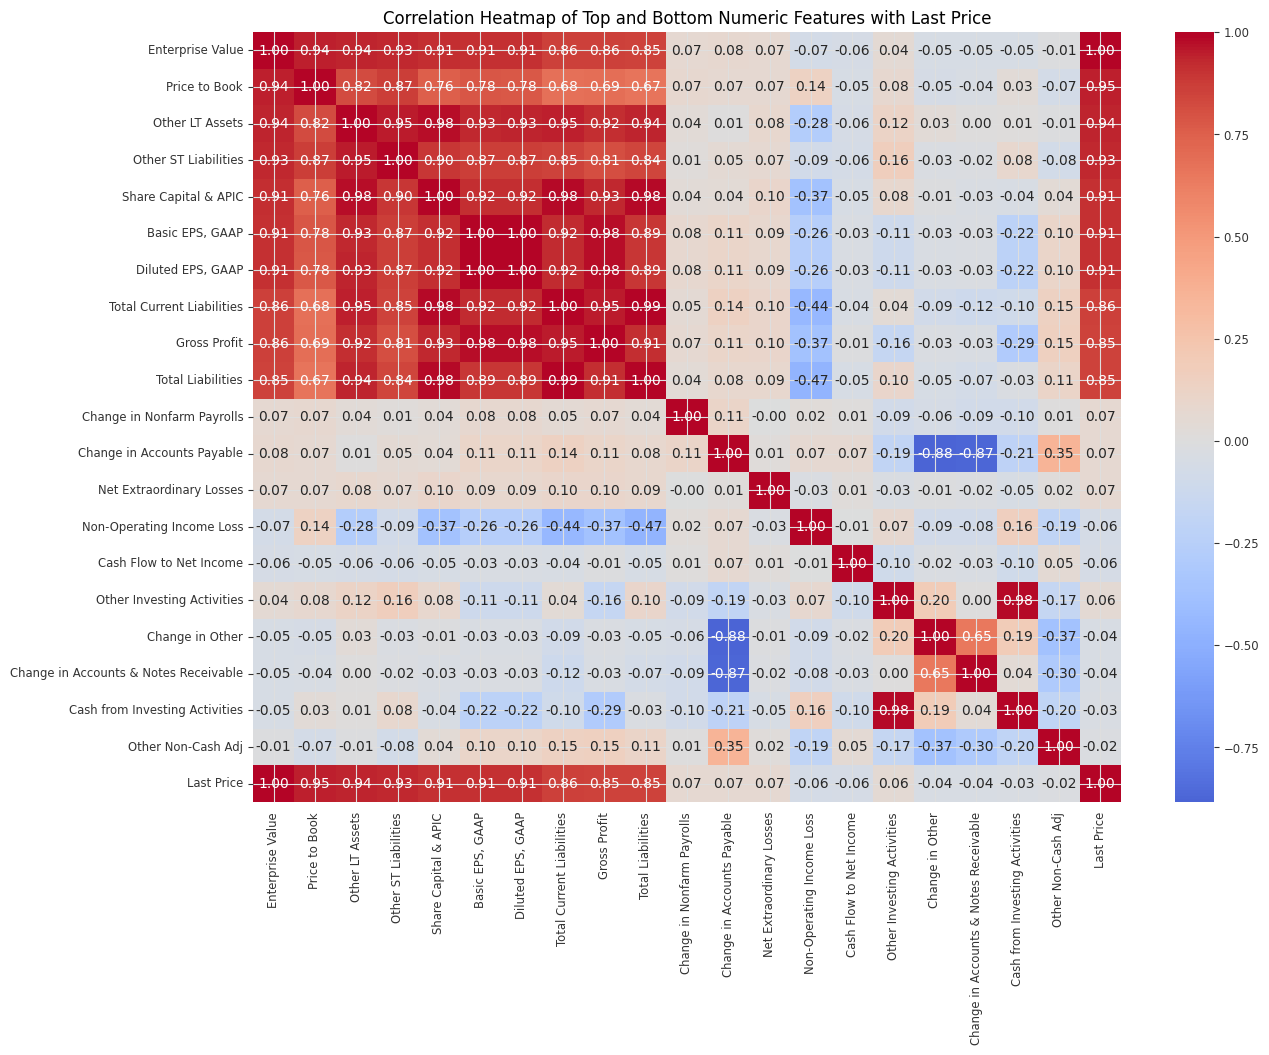

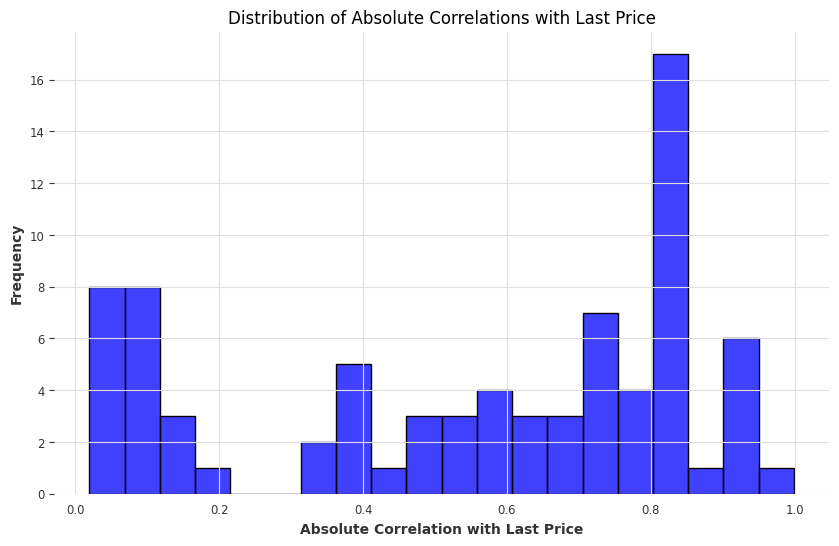

[I 2024-10-20 15:11:42,519] A new study created in memory with name: TFTModel_20241020151142


Found 62 value columns and 0 static columns


Missing logger folder: config_history/lightning_logs/TFTModel_20241020151142
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TFTModel.load_weights()` to load the weights for fine-tuning.
c:\Users\roman\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\roman\Desktop\Bot\config_history\ckpts\TFTModel_20241020151142 exists and is not empty.
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TFTModel.load_weights()` to load the weights for fine-tuning.
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TFTModel.load_weights()` to load the weights for fine-tuning.
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TFTModel.lo

c:\Users\roman\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\roman\Desktop\Bot\config_history\ckpts\TFTModel_20241020151142 exists and is not empty.
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TFTModel.load_weights()` to load the weights for fine-tuning.
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TFTModel.load_weights()` to load the weights for fine-tuning.
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TFTModel.load_weights()` to load the weights for fine-tuning.
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TFTModel.load_weights()` to load the weights for fine-tuning.


IndexError: index 0 is out of bounds for axis 0 with size 0

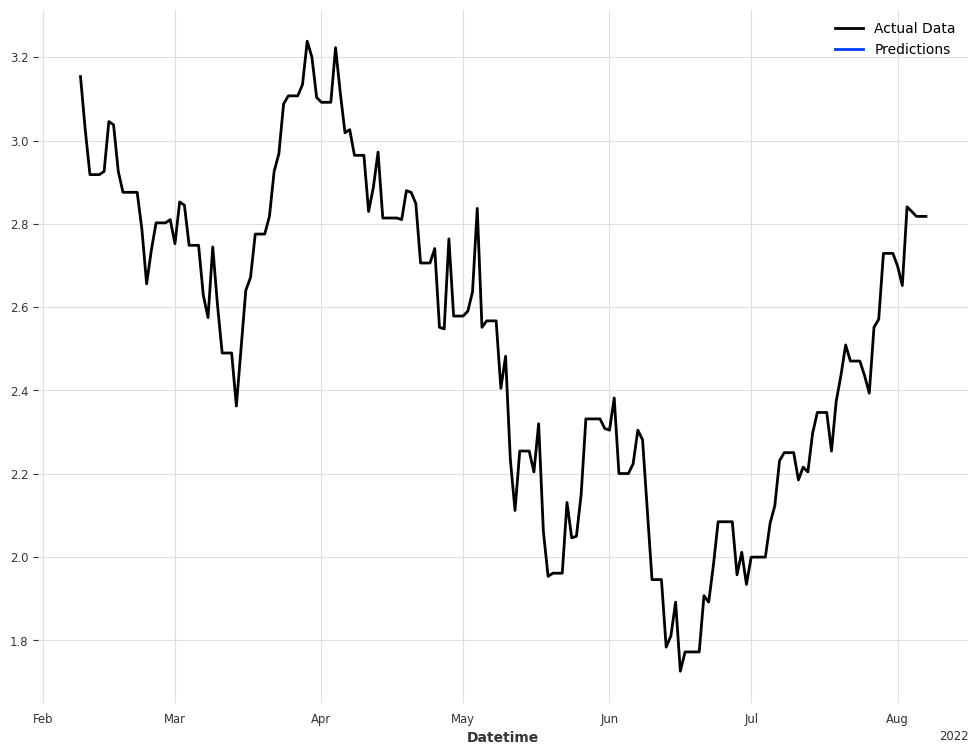

In [2]:
settings = {
    "name": "darts",
    "best": False,
    "pct": False,
    "optuna": True,
    "plot": 1,
    "direction": [-1, 1, 0][-1], # Whether to show largest decreases, increases, or both
    "target": "Last Price",
    "loss_name": ["MAPE", "RMSE", "MAE", "SMAPE", "MSE", "OPE", "RMSLE", "R2", "COV"][0],
    "secondary_loss": ["MAPE", "RMSE", "MAE", "SMAPE", "MSE", "OPE", "RMSLE", "R2", "COV"][1],
    "base_path": "config_history",
    "data_path": "Data/data.csv",
    "time_col_name": "Datetime",
    "group_col_name": "Ticker",
    "max_prediction_length": 90,
    "tuning_epochs": 10,
    "training_epochs": 100,
    "n_trials": 1,
    "n_splits": 5,
    "corr_thresh": 0.20,
    "train_test_pct": 0.75,
    "float_precision": ["medium", "high", "highest"][0],
    "validation": [None, "rolling"][-1],
    "scaling_method": [MinMaxScaler, StandardScaler][-1],
    "models": {
        "TFTModel": {
            "model_class": TFTModel,
            "supports_trainer_kwargs": True,
            "gradient_clip_val": 0.45,
            "model_parameters": {
                "input_chunk_length": 252,
                "output_chunk_length": 90,
                "hidden_size": 61,
                "lstm_layers": 2,
                "num_attention_heads": 11,
                "dropout": 0.1257,
                "hidden_continuous_size": 23,
                "optimizer_kwargs": {"lr": 1e-3},
                "add_relative_index": True,
                "use_static_covariates": False,
                "feed_forward": [
                "GatedResidualNetwork", "GLU", "Bilinear", "ReGLU", "GEGLU", "SwiGLU", "ReLU", "GELU"
                ][0],
            },
            "hyper_params": {
                "hidden_size": [1, 100],
                "lstm_layers": [1, 4],
                "num_attention_heads": [1, 16],
                "dropout": [0.1, 0.3],
                "hidden_continuous_size": [1, 100],
                "batch_size": [24, 48, 96],
                "n_epochs": [25, 50, 100],
                },
        },
    },
}
models = ModelEvaluator(settings)

# Simply training one model, for example
single_model = "TFTModel"
models.train(single_model)

# Analyzing and comparing all models
# models.run_all_models(tune=False)
# models.compare_models()